In [2]:
#set for reading images and displaying plots
import numpy as np
import sep
from astropy.io import fits
import matplotlib.pyplot as plt
from matplotlib import rcParams
import scipy.ndimage as ndimage
%matplotlib inline

## Let's show the image

In [67]:
#Store image into a 'data' array
data = fits.getdata('hlsp_hudf12_hst_wfc3ir_udfmain_f105w_v1.0_drz.fits', ext= 0)
data = data.byteswap(inplace=True).newbyteorder()
print(data)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


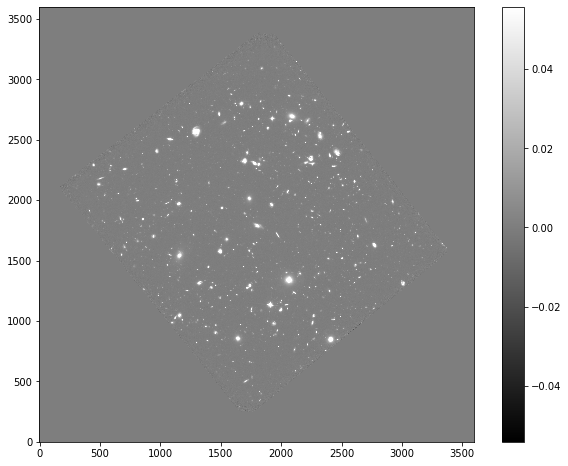

In [68]:
#the mean and standard deviation will be our parameters
m, s = np.mean(data), np.std(data)
rcParams['figure.figsize'] = [10., 8.]
plt.imshow(data, interpolation='nearest', cmap='gray', vmin=m-s, vmax=m+s, origin='lower')
#show the image with a colorbar
plt.colorbar()

## Calculate background and background clutter

0.0
0.0005398219218477607
This is the background which the sep background function calculated.


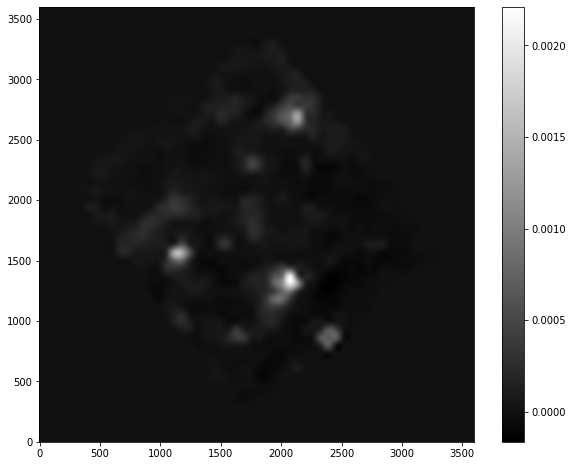

In [69]:
#measure a spatially varying background on our image
bkg = sep.Background(data)
print(bkg.globalback)
print(bkg.globalrms)

#evaluate background as a numpy 2-d array, same size as original image
bkg_image = np.array(bkg)

#show the background
plt.imshow(bkg_image, interpolation='nearest', cmap='gray', origin='lower')
plt.colorbar()
print(f'This is the background which the sep background function calculated.')

This is the background clutter of our background image.


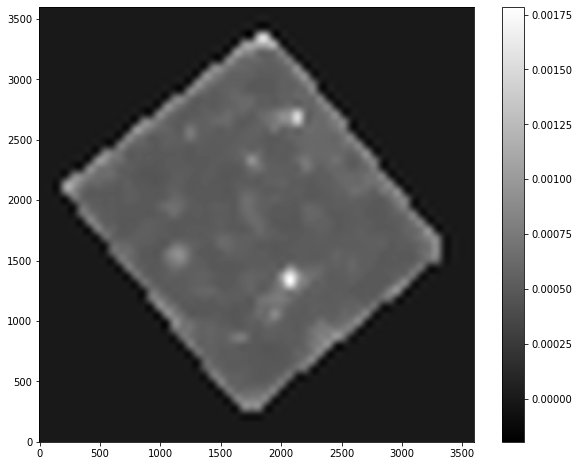

In [70]:
#Calculate background noise 
bkg_rms = bkg.rms()

#Show background noise
plt.imshow(bkg_rms, interpolation='nearest', cmap='gray', origin='lower')
plt.colorbar()
print(f"This is the background clutter of our background image.")

## Subtract background and run object detection

In [74]:
data_sub = data - bkg

#Extract the sources from our new image 
objects = sep.extract(data_sub, 10., err=bkg.globalrms)

#Let's see how many objects we detected
print(len(objects))

1545


Our detected objects are circled in red.


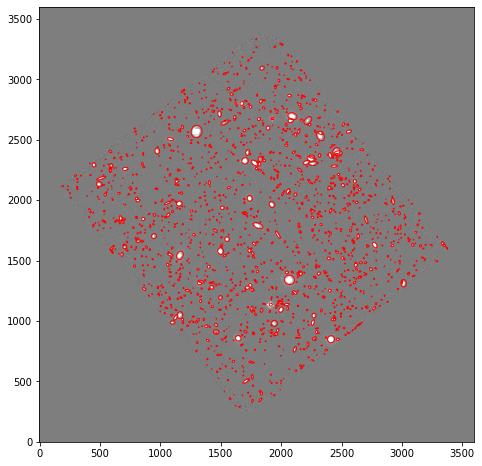

In [75]:
from matplotlib.patches import Ellipse

#plot background-subtracted image
fig, ax = plt.subplots()
m, s = np.mean(data_sub), np.std(data_sub)
im = ax.imshow(data_sub, interpolation='nearest', cmap='gray',
               vmin=m-s, vmax=m+s, origin='lower')

#plot an ellipse for each detected object
#Best method is to use a for loop that updates each object with a circle/ellipse
for i in range(len(objects)):
    e = Ellipse(xy=(objects['x'][i], objects['y'][i]),
                width=6*objects['a'][i],
                height=6*objects['b'][i],
                angle=objects['theta'][i] * 180. / np.pi)
    e.set_facecolor('none')
    e.set_edgecolor('red')
    ax.add_artist(e)
print(f"Our detected objects are circled in red.")

## Calculate their fluxes and histogram them

In [76]:
#creates simple circular aperture photometry with a 3 pixel radius at the locations of the objects
flux, fluxerr, flag = sep.sum_circle(data_sub, objects['x'], objects['y'], 3.0, err=bkg.globalrms, gain=1.0)
#flux, fluxerr, and flag are 1-d arrays
print(max(flux))

805.8583224487305


Text(0, 0.5, 'Number of instances ')

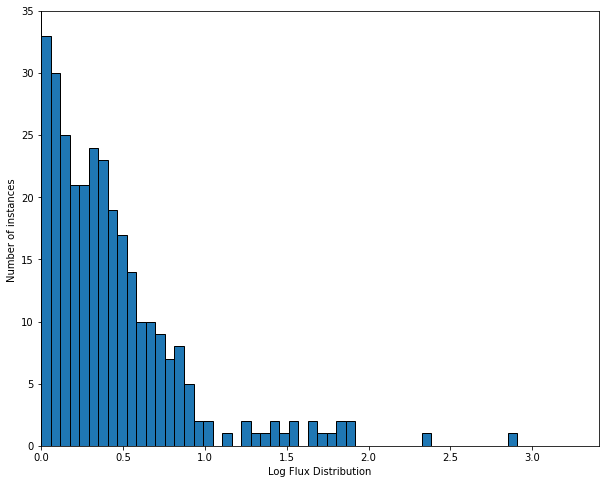

In [78]:
fig = plt.figure()
plt.xlim(0,np.log10(max(flux))+0.5)
plt.ylim(0,35)
plt.hist(np.log10(flux), bins=75, edgecolor = 'black')
plt.xticks(np.arange(0, np.log10(max(flux))+0.5, 0.5))
plt.xlabel('Log Flux Distribution')
plt.ylabel('Number of instances ')

In [79]:
#Get mean, median, and STD of flux
print(f"Mean: {np.mean(flux)}, Median: {np.median(flux)}, Standard Deviation: {np.std(flux)}")
print(f"Mean Log: {np.mean(np.log(flux))}, Median Log: {np.median(np.log10(flux))}, Standard Deviation Log: {np.std(np.log10(flux))}")

Mean: 1.8979036901375808, Median: 0.31320176973007624, Standard Deviation: 21.761801750809703
Mean Log: -0.8390579401199264, Median Log: -0.5041757926491033, Standard Deviation Log: 0.49367287149690564


In [80]:
print(f'Largest Log Outlier: {np.log10(max(flux))}')
print(f"Largest Log Outlier Coordinates : {objects['x'][1544],objects['y'][1544]}")
print(f"It is {np.log10(max(flux))/np.std(np.log10(flux))} standard deviations away from the mean")

Largest Log Outlier: 2.9062586954190253
Largest Log Outlier Coordinates : (1792.7518985895024, 3332.4781860203434)
It is 5.887013168470696 standard deviations away from the mean


## Make a 3 color false image of the UDF using RGB

In [94]:
import matplotlib.colors as colors

In [95]:
#Store our fit files
data2 = data
data3 = fits.getdata('hlsp_hudf12_hst_wfc3ir_udfmain_f125w_v1.0_drz.fits', ext=0)
data4 = fits.getdata('hlsp_hudf12_hst_wfc3ir_udfmain_f160w_v1.0_drz.fits', ext=0)

In [96]:
def rescale_image(data):
    pdata_tmp = data.copy()
    #nanmean ignores non values, best used for astro data
    m = np.nanmean(pdata_tmp)
    vplmin = m/2.
    vpmin = np.log10(vplmin)
    vpmax = np.log10(m*100)
    pdata_tmp[pdata_tmp<vplmin] = vplmin
    pdata_tmp = np.log10(pdata_tmp)
    return pdata_tmp, vpmin, vpmax

In [97]:
def fits_quicklook(data, fnx = 10, fny = 10):
    f = plt.figure(figsize=(fnx,fny))
    pdata_tmp, vpmin, vpmax = rescale_image(data)
    plt.imshow(pdata_tmp,vmin = vpmin, vmax = vpmax)

In [98]:
### Use these rescaled images
data_2_res, d2min, d2max = rescale_image(data2)
data_3_res, d3min, d3max = rescale_image(data3)
data_4_res, d4min, d4max = rescale_image(data4)

In [99]:
print(f"Min = {data_2_res.min()} Max = {data_2_res.max()}")
data_2_res[data_2_res<d2min] = d2min
data_2_res[data_2_res>d2max] = d2max
print(f"Min = {data_2_res.min()} Max = {data_2_res.max()}")

Min = -3.4026894569396973 Max = 1.8718441724777222
Min = -3.4026894569396973 Max = -1.1016594171524048


In [100]:
data_3_res[data_3_res<d3min] = d3min
data_3_res[data_3_res>d3max] = d3max
data_4_res[data_4_res<d4min] = d4min
data_4_res[data_4_res>d4max] = d4max

In [101]:
print(data_2_res.shape)
rgb = np.zeros((data_2_res.shape[0],data_2_res.shape[1],3))
print(rgb.shape)

(3600, 3600)
(3600, 3600, 3)


In [102]:
rgb[:,:,0] = (data_2_res-d2min)/(d2max-d2min)
rgb[:,:,1] = (data_3_res-d3min)/(d3max-d3min)
rgb[:,:,2] = (data_4_res-d4min)/(d4max-d4min)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


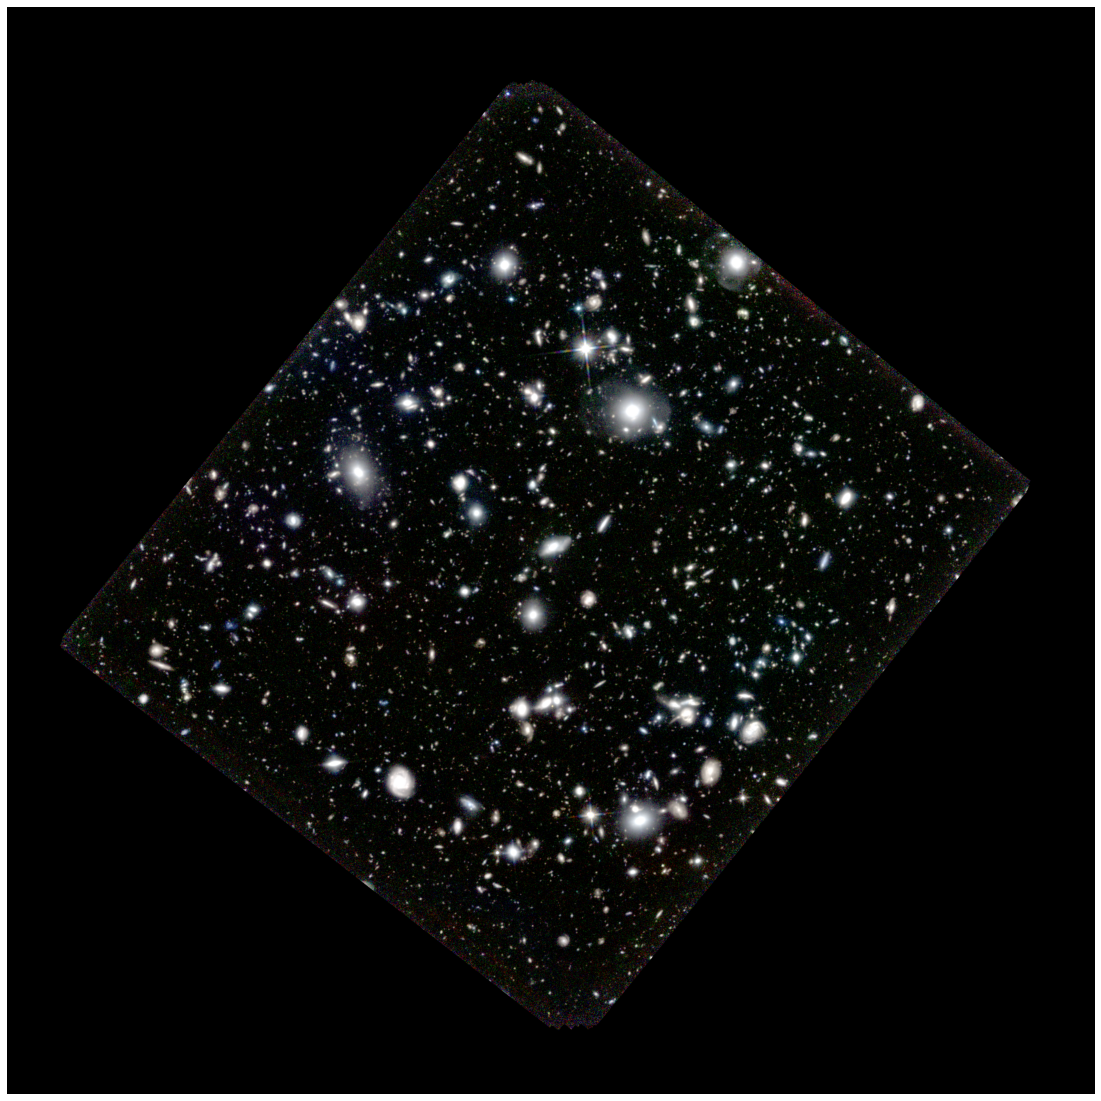

In [105]:
f, ax = plt.subplots(1,1,figsize = (20,20))
ax.axis('off')
ax.imshow(rgb)
plt.savefig('final_jwst.png',bbox_inches ='tight', pad_inches = 0, dpi = 600)